# 608 Project - Predicting bots from reddit comments

In [36]:
import math

import pandas as pd
import numpy as np
import scipy as sc

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.svm as svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Feature Ideas
- score per comment DONE
- standard deviation of minute posted (bots have low standard deviation - not random) DONE
- change in sentiment within each topic (users are consistent)
- change in length of comment (bots are consistent) DONE
- number of unique words used normalized by length of comment (users use more varied vocabulary)
- variation in amount of different subreddits (users are more varied) DONE

## Load in the Comment Data Sets

In [3]:
bot_comments = pd.read_csv("bot_comments_text.csv")
bot_comments['is_bot'] = 1
bot_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot
162566,[U Turn (2018)](https://movies.haus/movies/343...,moviescommentbot,1539396093,t3_9nq8qf,t3_9nq8qf,1,e7o6yzf,Tamilmv,1
190842,Applications are still open! Feel free to apply!,zelis42,1538944068,t3_9d9vro,t1_e7clksw,1,e7cpl91,Anxiety,1
112000,This is a Price Check thread. Offering on thes...,AutoModerator,1540160555,t3_9q7rpx,t3_9q7rpx,2,e87b20l,Dota2Trade,1


In [4]:
user_comments = pd.read_csv("user_comments_text.csv")
user_comments['is_bot'] = 0
user_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot
146568,Life insurace policy my dude.,Redneckalligator,1538377240,t3_9ka8hg,t1_e6yb3b9,10,e6yfn61,tumblr,0
596848,We might have a chance to see such at the conv...,Lethalmouse1,1539909627,t3_9pcerb,t1_e817599,1,e818848,Catholicism,0
271279,/u/dupreesdiamond I see here for Pitt's week 1...,ScaryCookieMonster,1539125160,t3_9mr9z2,t3_9mr9z2,2,e7hag47,CFB,0


Merge the data sets

In [5]:
combined_comments = pd.concat([user_comments, bot_comments])

Remove anything incorrectly tagges as a bot after a manual curation of the dataset

In [6]:
manual_labels = pd.concat([
    pd.read_csv("jon_results.csv"),
    pd.read_csv("ben_results.csv"),
    pd.read_csv("akio_results.csv"),
    pd.read_csv("yi_results.csv"),
])

combined_comments.loc[
    ~combined_comments.author.isin(
        manual_labels[manual_labels.label.notnull()].user.values
    ), 'is_bot'] = 0

## Calculate Per Comment Features

In [7]:
# convert the time_posted column to a datetime
combined_comments['time_posted'] = pd.to_datetime(combined_comments.created_utc, unit='s')
# extract the hour and minute from the time_posted
combined_comments['hour'] = combined_comments.time_posted.dt.hour
combined_comments['minute'] = combined_comments.time_posted.dt.minute
# get the number of words in each
combined_comments['num_words'] = combined_comments.body.apply(str).apply(str.split).apply(len)

In [35]:
combined_comments.sample(3)

,body,author,created_utc,link_id,parent_id,score,id,subreddit,is_bot,time_posted,hour,minute,num_words
226268,#### Hi there someToast!\n\nRegrettably your s...,AutoModerator,1539668706,t3_9okro2,t3_9okro2,1,e7usrvr,apple,1,2018-10-16 05:45:06,5,45,92
152897,"Hey, Vsauce! Micro here.",GoldSrc_or_Source,1540167743,t3_9q5wa8,t3_9q5wa8,27,e87iegr,BoneAppleTea,0,2018-10-22 00:22:23,0,22,4
13067,Aka executive DNC leadership,cuteman,1538765887,t3_9lh0kl,t1_e78alzf,1,e78c7hz,entertainment,0,2018-10-05 18:58:07,18,58,4


## Aggregate comment features by user

In [9]:
%%time
# group the fields we just calculated by author
by_user = pd.concat(
    [
        combined_comments.groupby('author').size(),
        combined_comments.groupby('author').score.mean(),
        combined_comments.groupby('author').minute.std(),
        combined_comments.groupby('author').num_words.std(),
        combined_comments.groupby('author').subreddit.nunique(),
        combined_comments.groupby('author').is_bot.max()
    ]
, axis=1)
# rename the columns to reflect the aggregate operations
by_user.columns = ['num_comments','mean_score', 'std_minute', 'std_num_words', 'num_unique_subs', 'is_bot']
# calculated new columns based on aggregated columns
by_user['unique_subs_per_comment'] = by_user.num_unique_subs / by_user.num_comments

Wall time: 3.05 s


In [10]:
by_user.sample(3)

,num_comments,mean_score,std_minute,std_num_words,num_unique_subs,is_bot,unique_subs_per_comment
author,,,,,,,
friendandadvisor,98,3.714286,18.071322,21.190114,3,0,0.030612
CharlieMike111,68,2.352941,15.876796,33.418371,17,0,0.250000
Pascalwb,102,2.696078,17.274503,11.154833,21,0,0.205882


Text(0.5,1,'Standard Deviation of Minute Posted - Users vs Bots')

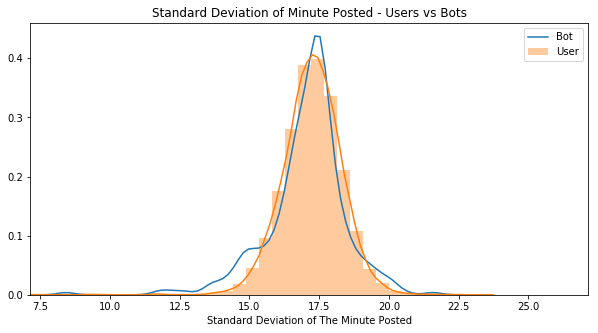

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.distplot(by_user.query("num_comments > 15 & is_bot == 1").std_minute, ax=ax, label="Bot", hist=False)
sns.distplot(by_user.query("num_comments > 15 & is_bot == 0").std_minute, ax=ax, label="User")

x_mean = by_user.std_minute.mean()
plt.xlim((x_mean-10, x_mean+10))

plt.xlabel("Standard Deviation of The Minute Posted")

ax.legend()
plt.title("Standard Deviation of Minute Posted - Users vs Bots")

## Machine Learning

Load in the network measures we calculated using the get_network_feats notebook

In [37]:
%%time
network_measures = pd.read_csv("node_measures_w_triads_nodupes.csv")
network_measures.set_index("node", inplace=True)

# these measures are causing issues
network_measures.drop(['avg_in_edge_weight', 'avg_out_edge_weight', 'bot'], axis=1, inplace=True)

Wall time: 3.32 s


In [38]:
network_measures.head()

,003,003_ratio,012,012_ratio,021C,021C_ratio,021D,021D_ratio,021U,021U_ratio,...,degree_centrality,ego_density,in_degree,in_degree_centrality,out_degree,out_degree_centrality,pagerank,reciprocity,sum_in_edge_weight,sum_out_edge_weight
node,,,,,,,,,,,,,,,,,,,,,
AutoModerator,1312215,0.999098,786,0.000598,0,0.000000,3,2.284148e-06,0,0.000000,...,0.002683,0.000476,601,0.001380,568,0.001304,4.029708e-04,0.365642,1350,1975
eat-sleep-fortnite,1306511,0.994755,3915,0.002981,2,0.000002,8,6.091061e-06,0,0.000000,...,0.000092,0.000969,23,0.000053,17,0.000039,1.597973e-05,0.647059,35,31
CommonMisspellingBot,1311619,0.998644,1384,0.001054,0,0.000000,1,7.613827e-07,0,0.000000,...,0.000985,0.000687,151,0.000347,278,0.000638,1.166757e-04,0.456401,16557,1202
hwsbot,2061,0.792692,292,0.112308,7,0.002692,12,4.615385e-03,0,0.000000,...,0.000025,0.053846,8,0.000018,3,0.000007,6.290281e-06,0.000000,9,3
Catebot,172703,0.921279,4690,0.025019,25,0.000133,30,1.600341e-04,3,0.000016,...,0.000005,0.023260,0,0.000000,2,0.000005,6.421734e-07,0.000000,0,2


Merge the text measures and the network measures into a single dataframe

In [41]:
data = pd.merge(by_user, 
                network_measures, 
                left_index=True, right_index=True)

# only use users with sufficient data
data = data.query("num_comments >= 5")

# remove any duplicate information we collected somehow (affects 42 rows)
data = data[data.index.isin(data.index.drop_duplicates())].copy()

# save the bot labels and column names so we can get them back after the scalar
bot_labels = data.is_bot
cols = data.columns

# run a scalar on the data
scaler = StandardScaler()
data = pd.DataFrame(
    scaler.fit_transform(data), 
    index=data.index,
    columns=cols
)
# reassign the bot labels
data.is_bot = bot_labels

## Hyperparameter Testing Functions

In [20]:
# data (REQUIRED) is dataset that includes all columns and labels
# column_list is list of columns to use as features
# - if all columns are desired don't pass in a parameter
# label_column (REQUIRED) is the column in the dataset that is the labels
# num_runs is the number of times to run each parameter setting
def run_SVC(data = [], column_list=[], label_column='', num_runs=10, verbose=False):
    if len(data) == 0 or label_column == '':
        print("You need to give me a dataset and a label column name")
        return
    if len(column_list) == 0:
        column_list = data.columns[data.columns != label_column]
    Cs = [1, 10, 100]
    gammas = [0.001, 0.01, 0.1]
    C_array = []
    gamma_array = []
    sens_array = []
    spec_array = []
    for i in range(num_runs):
        if verbose: print("i: " + str(i))
        train, test = train_test_split(data, test_size = 0.3)
        for C in Cs:
            for gamma in gammas:
                if verbose: print("C: " + str(C))
                if verbose: print("gamma: " + str(gamma))
                clf = svm.SVC(kernel='rbf', class_weight='balanced', C=C, gamma=gamma)
                clf.fit(train.loc[:,column_list], train[label_column])
                pred = clf.predict(test.loc[:,column_list])
                labels = pd.DataFrame(test[label_column])
                labels["pred"] = pred
                sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
                spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
                if verbose: print(sens)
                if verbose: print(spec)
                C_array.append(C)
                gamma_array.append(gamma)
                sens_array.append(sens)
                spec_array.append(spec)
    row_dict = {'C': C_array, 'gamma': gamma_array, 'sens': sens_array, 'spec': spec_array}
    row_df = pd.DataFrame(row_dict)
    row_df['acc'] = (row_df.sens + row_df.spec) / 2
    row_df = row_df.groupby(['C', 'gamma'], as_index=True).agg('mean')
    return(row_df)

In [24]:
# data (REQUIRED) is dataset that includes all columns and labels
# column_list is list of columns to use as features
# - if all columns are desired don't pass in a parameter
# label_column (REQUIRED) is the column in the dataset that is the labels
# num_runs is the number of times to run each parameter setting
def run_rf(data = [], column_list=[], label_column='', num_runs=10, verbose=False):
    if len(data) == 0 or label_column == '':
        print("You need to give me a dataset and a label column name")
        return
    if len(column_list) == 0:
        column_list = data.columns[data.columns != label_column]
    num_features = len(column_list)
    trees = [2, 10, 100]
    n_feats = [math.ceil(num_features / 10), math.ceil(num_features / 5), 
               math.ceil(num_features / 2), math.ceil(num_features / 1)]
    tree_array = []
    feat_array = []
    sens_array = []
    spec_array = []
    for i in range(num_runs):
        if verbose: print("i: " + str(i))
        train, test = train_test_split(data, test_size = 0.3)
        for tree in trees:
            for feat in n_feats:
                if verbose: print("trees: " + str(tree))
                if verbose: print("n_feats: " + str(feat))
                clf = RandomForestClassifier(class_weight='balanced', n_estimators=tree, max_features=feat)
                clf.fit(train.loc[:,column_list], train[label_column])
                pred = clf.predict(test.loc[:,column_list])
                labels = pd.DataFrame(test[label_column])
                labels["pred"] = pred
                sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
                spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
                if verbose: print(sens)
                if verbose: print(spec)
                tree_array.append(tree)
                feat_array.append(feat)
                sens_array.append(sens)
                spec_array.append(spec)
    row_dict = {'trees': tree_array, 'n_feats': feat_array, 'sens': sens_array, 'spec': spec_array}
    row_df = pd.DataFrame(row_dict)
    row_df['acc'] = (row_df.sens + row_df.spec) / 2
    row_df = row_df.groupby(['trees', 'n_feats'], as_index=True).agg('mean')
    return(row_df)

### SVC Testing for text only features, network only features, and combined features

In [21]:
%%time
run_SVC(
    data = data, 
    column_list = ['num_comments', 'mean_score', 'std_minute', 'std_num_words','num_unique_subs', 'unique_subs_per_comment'],
    label_column = 'is_bot', 
    num_runs = 10).to_csv("svc_results_text.csv")

Wall time: 2min 8s


In [22]:
%%time
run_SVC(
    data = data, 
    column_list = network_measures.columns.values,
    label_column = 'is_bot', 
    num_runs = 10).to_csv("svc_results_network.csv")

Wall time: 3min 14s


In [23]:
%%time
run_SVC(
    data = data, 
    label_column = 'is_bot', 
    num_runs = 10).to_csv("svc_results_combined.csv")

Wall time: 2min 59s


### Random Forest Testing for text only features, network only features, and combined features

In [25]:
%%time
run_rf(
    data = data, 
    label_column = 'is_bot', 
    num_runs = 10).to_csv("rf_results_combined.csv")

Wall time: 3min 50s


In [26]:
%%time
run_rf(
    data = data, 
    column_list = network_measures.columns.values,
    label_column = 'is_bot', 
    num_runs = 10).to_csv("rf_results_network.csv")

Wall time: 3min 2s


In [27]:
%%time
run_rf(
    data = data, 
    column_list = ['num_comments', 'mean_score', 'std_minute', 'std_num_words','num_unique_subs', 'unique_subs_per_comment'],
    label_column = 'is_bot', 
    num_runs = 10).to_csv("rf_results_text.csv")

Wall time: 58.9 s


## Find the most important features using a random forest classifier

In [57]:
# split the data into training and test sets
train, test = train_test_split(data, test_size = 0.3)

# identify the label column and the feature columns
label_column = 'is_bot'
column_list = [x for x in data.columns if x is not label_column]

# run the classifier
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_features=51)
clf.fit(train.loc[:,column_list], train[label_column])
pred = clf.predict(test.loc[:,column_list])
labels = pd.DataFrame(test[label_column])
labels["pred"] = pred
sens = len(labels.query("is_bot == 1 and pred == 1")) / len(labels.query("is_bot == 1"))
spec = len(labels.query("is_bot == 0 and pred == 0")) / len(labels.query("is_bot == 0"))
print("Sensitivity:", sens)
print("Specificity:", spec)
print("Accuracy:",(sens + spec) / 2)

Sensitivity: 0.330188679245283
Specificity: 0.9952194697957409
Accuracy: 0.6627040745205119


### Most important features

In [55]:
pd.DataFrame({
    "import":clf.feature_importances_,
    "col":column_list
}).sort_values("import", ascending=False)

,import,col
0,0.206626,num_comments
3,0.107879,std_num_words
42,0.094414,ego_density
21,0.089305,102_ratio
9,0.077957,012_ratio
1,0.075490,mean_score
5,0.039769,unique_subs_per_comment
4,0.036605,num_unique_subs
48,0.032645,reciprocity
2,0.026564,std_minute
